# Author: Dominik Stipić

# NLP


In [0]:
from google.colab import drive
drive.mount("/content/gdrive")
!pip install emoji
!pip install langdetect

In [0]:
import nltk
import pandas as pd
import os
import sklearn
import emoji
import numpy as np
from nltk.corpus import wordnet 
from nltk.corpus import sentiwordnet as sw
import pdb
import re
import langdetect

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')
os.getcwd()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


'/content'

In [0]:
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/train.tsv", delimiter="\t")
test  = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/test.tsv", delimiter="\t")

train = train.drop(["id"], axis=1)
test  = test.drop(["id"], axis=1)

train.head()

message type  human   sex
0  RT @ChassNews: A hard-earned victory over the ...   RT  human  male
1  RT @jburnmurdoch: NEW: how Swansea City have r...   RT  human  male
2                In memoriam https://t.co/3VV0JHvtgz   TW  human  male
3  RT @tedgioia: R.I.P. Cecil Taylor (1929-2018),...   RT  human  male
4  RT @robertshrimsley: Moses and Pharaoh - the C...   RT  human  male

In [0]:
test.describe()
train.describe()

message    type   human     sex
count                         409072  409072  409072  409072
unique                        370988       2       2       3
top     wow, it's so sad about MJ :(      TW     bot     bot
freq                             136  325268  205014  205014

In [0]:
#Classes
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

class Tokenizer(BaseEstimator):
    """
        Tokenizes the sentance
    """
    def __init__(self):
        self.tokenizer = RegexpTokenizer(r'\w+')
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        xs = self.tokenizer.tokenize(x)
        words = [w.lower() for w in xs]
        return words

    
class Stopword_Remover(BaseEstimator):
    """
        Removes common stopwords
    """
    def __init__(self):
        self.stop = set(stopwords.words("english"))
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, words):
        ws = [word for word in words if word not in self.stop]
        return ws
    
class Stemmer(BaseEstimator):
    """
        Stemmes the word using Portter Stemmer
    """
    def __init__(self, use_porter=True):
        if use_porter:
            self.stemmer = nltk.PorterStemmer()
        else:
            self.stemmer = nltk.LancasterStemmer()
            
    def fit(self, x, y=None):
        return self
    
    def transform(self, words):
        words = [self.stemmer.stem(word) for word in words]
        return words

class POS_tagger(BaseEstimator):
    """
        Pos_tagging of words
    """
    def fit(self, x, y=None):
        return self
    
    def transform(self, words):
        words = nltk.pos_tag(words)
        return words
    
    
class Lemmatizer(BaseEstimator):
    """
        Lemmatizes the words or converts them to standard dict form
    """
    def __init__(self):
        self.lemmer = nltk.WordNetLemmatizer()
    
    def fit(self, x, y=None):
        return self
    
    def get_wordnet_pos(self, word):
        from nltk.corpus import wordnet
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    def transform(self, items):
        words = [self.lemmer.lemmatize(word, pos=self.get_wordnet_pos(pos)) for word, pos  in items]
        return words

class EmojiFilter(BaseEstimator):
    """
        Replaces emojis with text
    """
    def fit(self, x, y=None):
        return self
    
    def transform(self, tweet):
        tweet = emoji.demojize(tweet)
        tweet = tweet.replace(":"," ")
        tweet = ' '.join(tweet.split())
        return tweet
    
    
class RegexFilter(BaseEstimator):
    """
        Cleans the words which match given regex
    """
    def __init__(self, regex):
        self.reg = regex
    
    def fit(self, x, y=None):
        return self
    
    def find(self, sentance):
        xs = re.findall(self.reg,sentance)
        return xs
    
    def transform(self, sentance):
        patterns = self.find(sentance)
        for pattern in patterns:
            sentance = sentance.replace(pattern,"") 
        return sentance

    
class DigitRemover(BaseEstimator):
    def fit(self, x, y=None):
        return self
    
    def transform(self, sentance):
        result = ''.join([i for i in sentance if not i.isdigit()])
        return result
    
class WordNetTransform(BaseEstimator):
    """
        Converts the word to standard wordnet lemma and chooses corect word sense
    """
    def fit(self, x, y=None):
        return self

    def squeze_list(self, xs):
        flatList = []
        for elem in xs:
            flatList.extend(elem)
        return flatList
    
    def longestSubstring(self, str1,str2):
        from difflib import SequenceMatcher
        seqMatch = SequenceMatcher(None,str1,str2) 
        match = seqMatch.find_longest_match(0, len(str1), 0, len(str2))
        return match.size
    
    def transform(self, words):
        def fun(word):
            synsets = wordnet.synsets(word)
            if not synsets:
                return ""
            lemmas = [syn.lemma_names() for syn in synsets]
            # [[]] -> []
            lemmas = self.squeze_list(lemmas)
            # Choose the word sense which is syntaticlly most simmilar to given word
            lemmas = map(lambda x : (x, self.longestSubstring(x, word)), lemmas)
            name = max(lemmas, key = lambda x : x[1] )[0]
            return name
                
        words = [fun(word).lower() for word in words if len(fun(word)) > 0]
        return words   
    
class LanguageChecker(BaseEstimator):
    "Checks wheter language is english"
    def fit(self, x, y=None):
        return self

    def transform(self, words):
        sentance = " ".join(words).strip()
        if not(sentance):
            return []
        
        try:
            value = langdetect.detect(sentance)
            if value != "en":
                return []
            return words
        except Exception:
            with open("./mylog","a") as f:
                f.write(sentance + "\n")
                
##############################

def write_corpus(corpus, name):
    with open(name, 'w') as f:
        for item in corpus:
            f.write("%s\n" % item)

In [0]:
url_regex     = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
mention_regex = "@\w+"
hashtag_regex = "#\w+"
number_regex  = ".[0-9]+."
punc_regex    = "[!\"#$%&\\\\'()“”*…'+,-.''/:;'<=>?@\[\]^_`{|}~–]+"


pipe = Pipeline([
    ("url_cleaner", RegexFilter(url_regex)),
    ("mention_cleaner", RegexFilter(mention_regex)),
    ("hashtag_cleaner", RegexFilter(hashtag_regex)),
    ("rt_cleaner", RegexFilter("^RT")),
    ("number_cleaner", DigitRemover()),
    ("emoji_filter", EmojiFilter()),
    ("punc_cleaner", RegexFilter(punc_regex)),
    ("dots_remover", RegexFilter("…")),
    
    ("tokenizer", Tokenizer()),
    ("stopword", Stopword_Remover()),
    ("pos_tagger", POS_tagger()),
    ("lemmatizer", Lemmatizer()),
    #("wordnet_transform", WordNetTransform())
])

p = Pipeline([
    ("url_cleaner", RegexFilter(url_regex)),
    ("mention_cleaner", RegexFilter(mention_regex)),
    ("hashtag_cleaner", RegexFilter(hashtag_regex)),
    ("rt_cleaner", RegexFilter("^RT")),
    ("number_cleaner", RegexFilter(number_regex)),
    ("emoji_filter", EmojiFilter()),
    ("punc_cleaner", RegexFilter(punc_regex)),
    ("dots_remover", RegexFilter("…")),
    
    ("tokenizer", Tokenizer()),
    ("stopword", Stopword_Remover()),
    ("pos_tagger", POS_tagger()),
    ("lemmatizer", Lemmatizer())
])

S = [
    "SharePoint Developer: Description:The Treasury Solutions &amp;#38; Development (TSD) Organization supports the Total Information Processing Support Services (TIPSS) contract vehicle which is used by the Internal Revenue Service (IRS) for IT contractor… https://t.co/sWq7fAzFuz",
    "HR Systems Integration Specialist: Overview Love working with people? Passionate about technology? We’re looking for a tech enthusiast with a project manager mindset to join our team as an Integration Specialist II, where you’ll serve as the technical… https://t.co/1TdFEeEiAJ",
    "RT @NicolaSturgeon: 💚 Congratulations to @Together4yes and the people of Ireland. Compassion, justice and trust in women win the day. Joyfu…",
    "RT @VisitScotland: Follow in the real footsteps of @SamHeughan on this epic 12 day #Outlander itinerary! https://t.co/Q5Gqj9IwaQ 📷 @weloveh…",
    "RT @ImmersiveMinds: Are you at #BETT2018 this week? Whether it's #Minecraft, #Microbits, #Makerspaces you're interested in - or just want t…",
    "ETL Developer: Job Ref: ********** Employer: NTT DATA Country: United States County/State: Massachussetts Address: Post Date: 24/08/2018 00:10 Req ID: 28886 At NTT DATA Services, we know that with the right people on board, anything is possible. The… https://t.co/Nyc2n0bOzY https://t.co/hSf5IxEage",
    "Front End Developer: Front End Developer – ̣ Wellesley Hills, MA 02481 – ********** – Find Jobs – Company Reviews – Find Salaries – Find Resumes – Employers / Post Job – Upload your resume – Sign in Home whatjob title, keywords, or company wherecity,… https://t.co/G6FXUpovH5 https://t.co/s5LUEe4a5C",
    "Java developer: ******/Java developer Ref No.: 18-33445 Location: Quincy – Massachusetts, Massachusetts DEVELOPER-L3 Job Description(As per hiring manager) Key skills required for the job are: Microservices-L3 (Mandatory) Java-J2EE-L3 As a Senior… https://t.co/q5oFjKcVEj https://t.co/Qk1BpP5OQR",
    "RT @WEConnectEurope: #fq2 @navarro_marcela speaking about women-owned businesses and their access to all different types of finance. https:…",
    "RT @meronina: This is the kind of gesture I want to hear, Radio Erena reports 400 religious prisoners released. #Eritrea https://t.co/XZY…",
    "RT @LeahHardingAJE: Not fake news. @amnesty says the video of two women and two children being executed in #Cameroon is real, and that the…",
    "Can there be a expansion movie about #jawas?",
    "Sadly many did: “worth it at any price”. https://t.co/TkaP9Zgpuk",
    "@almurray “T'ha'n'k you” My favourite film.",
    "Krivo :: RT @77MASH: 🤘 🤘 https://t.co/vcUZ6OV3Rf", 
    "RT @nkjemisin: 😂😂😂 https://t.co/bvqMhA7nmF",
    'He is 😳',
    "RT @MotorheadPhil: Hard to believe only Mik and myself left on this bittersweet foto ♠️ https://t.co/YAYNy5aiN1",
    "I am getting into the mood for tonight's #RockJukeBoxChallenge with @Kezzang69 who has already increased the scope you the years and included singles-he is threatened to wear his 80's rock threads....no matter what it will be loud🤘",
    "Giving Boris Johnson the keys to Number 10 would be like holding a Black Friday sale in a whorehouse, a well-lubricated orgy of shuddering bellies, blapping and brou-ha-ha.  👏👏Just LOL'd to that https://t.co/fNNaprIS3l",
    "SDET – Integration Testing with Parasoft and SQL Experience: SDET – Integration Testing with Parasoft and SQL Experience in Charlotte, North Carolina, United States | IT Infrastructure at CognizantJob Details | Cognizant – ************* – Industries – –… https://t.co/07X0d0DExd https://t.co/fO5GkrhUmt",
    "On middle far of October DM+MD MY SOUL ON FIRE will rock the New York city at Madison Square Garden arena which will... http://t.co/f2s75m5B",
    "RT @tedgioia: R.I.P. Cecil Taylor (1929-2018), one of the great innovators in modern music. I had a chance to meet him when I was a student…",
    "RT @CPolF5: La stratégie d\'Emmanuel Macron est très simple : il veut être seul face à Mélenchon et Le Pen, et il veut que le débat se résu…",
    "Ja sam Dominik, a tko si ti Hello Šta Help where do you leave",
    "saturday paper hello",
    "0.039357374740876916",
    "01112.30",
    "RT @PaulBlu: ExxonMobil has a $300b drilling d...",
    "....9.0...9.9.9..222 ad asd qwe  sd   asdsda 12 ..31 .. .. 12",
     "</dskdkaks> or <asdasdk/>  sfsdf' sdsdfs asdas1`d  asdasdsd assvd&&fv``dv<  &gt"]
s = S[-1]
print(s)
pipe.fit_transform(s)

In [0]:
def get_corpus(df, pipe, write=False):
    """
       Gets word corpus 
    """
    messages = df["message"]
    X = np.array([])
    for i,message in enumerate(messages):
        if i%100 == 0 and write:
            print(f"{i/len(messages)*100}")
        message = message.strip()
        words = pipe.fit_transform(message)
        sentance = " ".join(words)
        X = np.append(X, sentance)            
    Y = df["sex"]    
    mask = X != ""
    return X[mask], Y[mask]

def read_corpus(name):
    X = []
    with open(name,"r") as f:
        for line in f:
            X.append(line.strip())
    return X
    

In [0]:
X,Y = get_corpus(train.head(100), pipe)

In [0]:
sentance = X[1]
print(sentance)
words = sentance.split()
words
target = words[7]
print("**" + target)
syns = wordnet.synsets(target)

from nltk.wsd import lesk
lesk(sentance, target).definition()

new swansea city regressed model club playing possession football shoestring scrappy longb
**possession


'a territory that is controlled by a ruling state'

# WSD




In [0]:
from nltk.wsd import lesk

syns = wordnet.synsets("bank")
s = "I went to the bank"
l = lesk(s.split(), "bank", "n")
print(l)
print(l.definition())

Synset('savings_bank.n.02')
a container (usually with a slot in the top) for keeping money at home


# Sentiment

In [0]:
x_train = X1
y_train = Y1

In [0]:
len(train)

409072

In [0]:
def get_sentiment_score(word):
    xs = list(sw.senti_synsets(word))
    S = [[x.pos_score(), x.neg_score(), x.obj_score()] for x in xs]
    S = np.array(S)
    return S.mean(axis=0)

def get_sentance_sentiment(sentance):
    words = sentance.split()
    senti_matrix = []
    for word in words:
        S = get_sentiment_score(word)
        senti_matrix.append(S)
    senti_matrix = np.array(senti_matrix)
    return senti_matrix.mean(axis=0)
    

sentiments = []
for sentance in x_train:
    S = get_sentance_sentiment(sentance)
    sentiments.append(S)

In [0]:
f = []
m = []
for xs, y in (zip(sentiments, y_train)):
  if y == "female":
    f.append(xs)
  else:
    m.append(xs)

f = np.array(f)
m = np.array(m)

In [0]:
import matplotlib.pyplot as plt
n = 40
plt.hist(f[:,2], bins = n)
plt.hist(m[:,2], bins = n)

In [0]:
model = MultinomialNB().fit(sentiments, y_train)

# Text Preprocessing in sklearn


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

corpus = [
    'This is the first document',
    'This document is the second document',
    'And this is the third--2 one.',
    'Is this the first document?',
]

count_vect = CountVectorizer()
X = count_vect.fit_transform(corpus)
print(count_vect.get_feature_names())
print(X.toarray())
print()

vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
X2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']


# MALE vs. FEMALE CLASSIFICATION

In [0]:
def get_male_female_data(X,Y):
    Z = [(document,label) for document, label in zip(X, Y) if label in ["male", "female"]]
    res = [[ i for i, j in Z ], 
           [ j for i, j in Z ]]
    return res[0], res[1]


In [0]:
X,Y = get_male_female_data(x_train, y_train)
input_test, target_test = get_male_female_data(x_test, y_test)

In [0]:

text_clf = Pipeline([('count', CountVectorizer()),
                    ('tfid', TfidfTransformer()), 
                    ("clf", MultinomialNB())])

text_clf = text_clf.fit(X,Y)

In [0]:
y_pred      = text_clf.predict(input_test)
class_names = list(set(target_test)) 
report = metrics.classification_report(target_test, 
                                    y_pred,
                                    target_names=class_names)

print(report)

# WORD2Vec



In [0]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, IncrementalPCA
import pdb
import matplotlib.pyplot as plt
from google.colab import drive
import gensim
import seaborn as sns

drive.mount("/content/gdrive")
!pip install ipython-autotime
%load_ext autotime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


time: 57.3 s


In [0]:
v1 = model.word_vec("goal")
v2 = model.word_vec("politics")
v = v1+v2
model.similar_by_vector(v)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('politics', 0.7266120910644531),
 ('goal', 0.6952168941497803),
 ('goals', 0.5570492744445801),
 ('partisan_politics', 0.532209038734436),
 ('Lisa_Vorderbrueggen_covers', 0.5268320441246033),
 ('Politics', 0.5129055380821228),
 ('political', 0.5032199621200562),
 ('JIM_HAND_covers', 0.4794444441795349),
 ('ideology', 0.46214017271995544),
 ('Parochialism', 0.4602662920951843)]

In [0]:
def get_most_similar_word(v):
  return max(model.similar_by_vector(v), key = lambda x : x[1])[0]

def cos_sim(v1,v2):
  r = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
  return r

def read_corpus(name):
    X = []
    Y = []
    with open(name,"r") as f:
        for line in f:
            m,y = line.split(",")
            X.append(m.strip())
            Y.append(y.strip())
    return X,Y   

# cos_sim(v1,v2)
# get_most_similar_word(v2)

In [0]:
x_train, y_train = read_corpus("/content/gdrive/My Drive/Colab Notebooks/data/corpus/train_clean2")  

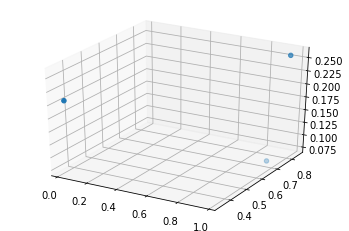

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.random.random((3,3))
ax.scatter(X[:,0],X[:,1],X[:,2])

In [0]:
data = zip(x_train, y_train)
male = []
bot = []
female = []

for i, (text, y) in enumerate(data):
  if y == "bot":
    bot.append(text)
  elif y == "male":
    male.append(text)
  else:
    female.append(text)


In [0]:
def get_pca(data, n=None):
  X = np.array([])
  text = np.array([])
  for i, message in enumerate(data):
    if n and i > n:
      break
    words = message.split()
    xs = []
    for w in words:
      try:
        v = model.word_vec(w)
        xs.append(v)
      except Exception:
        pass    
    xs  = np.array(xs)
    if len(xs) == 0:
      continue
    res = xs.sum(axis=0) 
    if len(X) == 0:
      X = np.array(res)
    else:
      X = np.vstack([X,res])
  return X

b = get_pca(bot, 1000)
m = get_pca(male, 1000)
f = get_pca(female, 1000)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


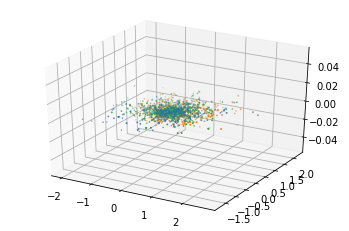

In [0]:
pca_b = PCA(3).fit_transform(b)
pca_m = PCA(3).fit_transform(m)
pca_m = PCA(3).fit_transform(f)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(b[:,0],b[:,1],b[:,2],label = "bot")
plt.scatter(m[:,0],m[:,1],m[:,2],label = "male")
plt.scatter(f[:,0],f[:,1],f[:,2],label = "female")

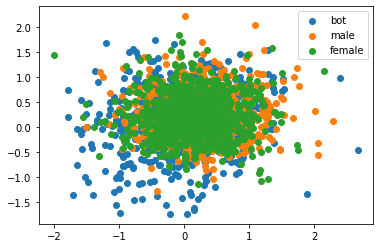

In [0]:
pca_b = PCA(2).fit_transform(b)
pca_m = PCA(2).fit_transform(m)
pca_m = PCA(2).fit_transform(f)


plt.scatter(b[:,0],b[:,1],label = "bot")
plt.scatter(m[:,0],m[:,1],label = "male")
plt.scatter(f[:,0],f[:,1],label = "female")
plt.legend()

#TSNE



In [0]:
def get_data(data, n=None):
  X = np.array([])
  txt = []
  text = np.array([])
  for i, message in enumerate(data):
    if n and i > n:
      break
    words = message.split()
    xs = []
    for w in words:
      try:
        v = model.word_vec(w)
        xs.append(v)
      except Exception:
        pass    
    xs  = np.array(xs)
    if len(xs) == 0:
      continue
    res = xs.sum(axis=0) 
    if len(X) == 0:
      X = np.array(res)
    else:
      X = np.vstack([X,res])
    txt.append(message.split())
  return X,(txt)

bot_num,bot_txt        = get_data(bot, 50)
male_num,male_txt      = get_data(male, 1000)
female_num,female_txt  = get_data(female, 1000)

time: 636 ms


In [0]:
tsne = TSNE(n_components=2, random_state=0)
B = tsne.fit_transform(bot_num)
M = tsne.fit_transform(male_num)
F = tsne.fit_transform(female_num)

time: 2min 35s


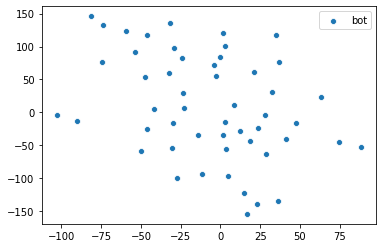

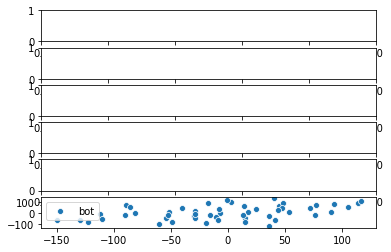

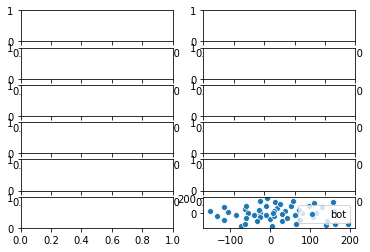

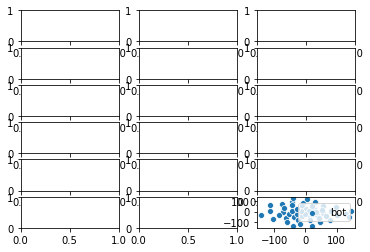

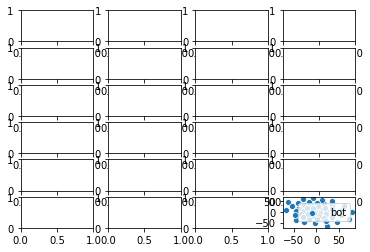

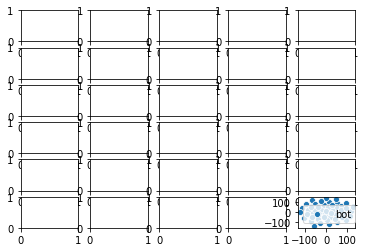

time: 10.7 s


In [0]:
xs = [5,10,20,30,40,50]


for i, p in enumerate(xs):
  X = TSNE(n_components=2, perplexity=p).fit_transform(bot_num)
  plt.subplots(6,i)
  sns.scatterplot(X[:,0],X[:,1],label="bot")



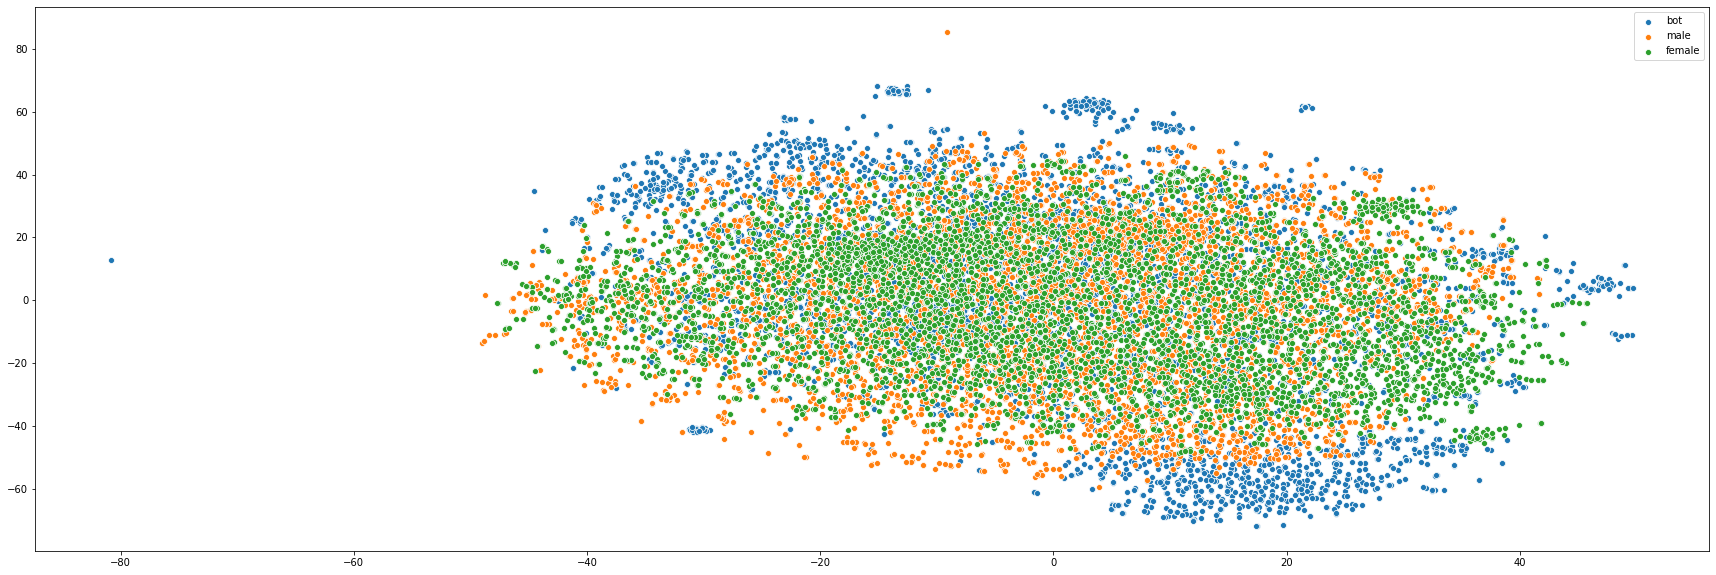

time: 596 ms


In [0]:
plt.figure(figsize = (30,10))
sns.scatterplot(B[:,0],B[:,1],label="bot")
sns.scatterplot(M[:,0],M[:,1],label="male")
sns.scatterplot(F[:,0],F[:,1],label="female")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


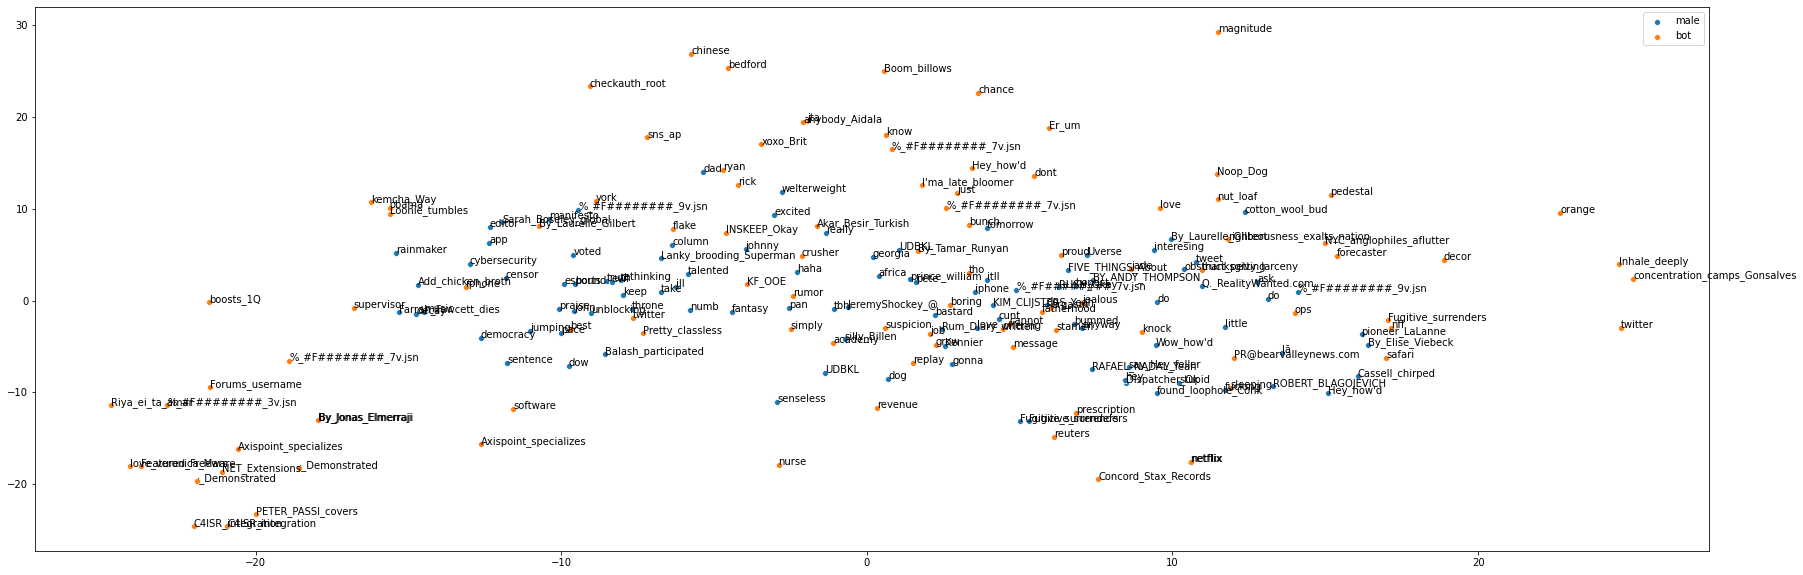

In [0]:
def plot_and_annotate(X,T,title,write=False, v = False):
  for i in range(len(X)):
    if i % 10 and i > 0 and False:
      print(f"{i/len(X)*100}")
    label = get_most_similar_word(X[i])
    x,y = T[i]
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
  sns.scatterplot(T[:,0],T[:,1], label = title)
  plt.legend()



plt.figure(figsize = (30,10))
n = 200
delta = 100
plot_and_annotate(male_x[n:n+delta],M[n:n+delta],"male")
plot_and_annotate(bot_x[n:n+delta],B[n:n+delta],"bot")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


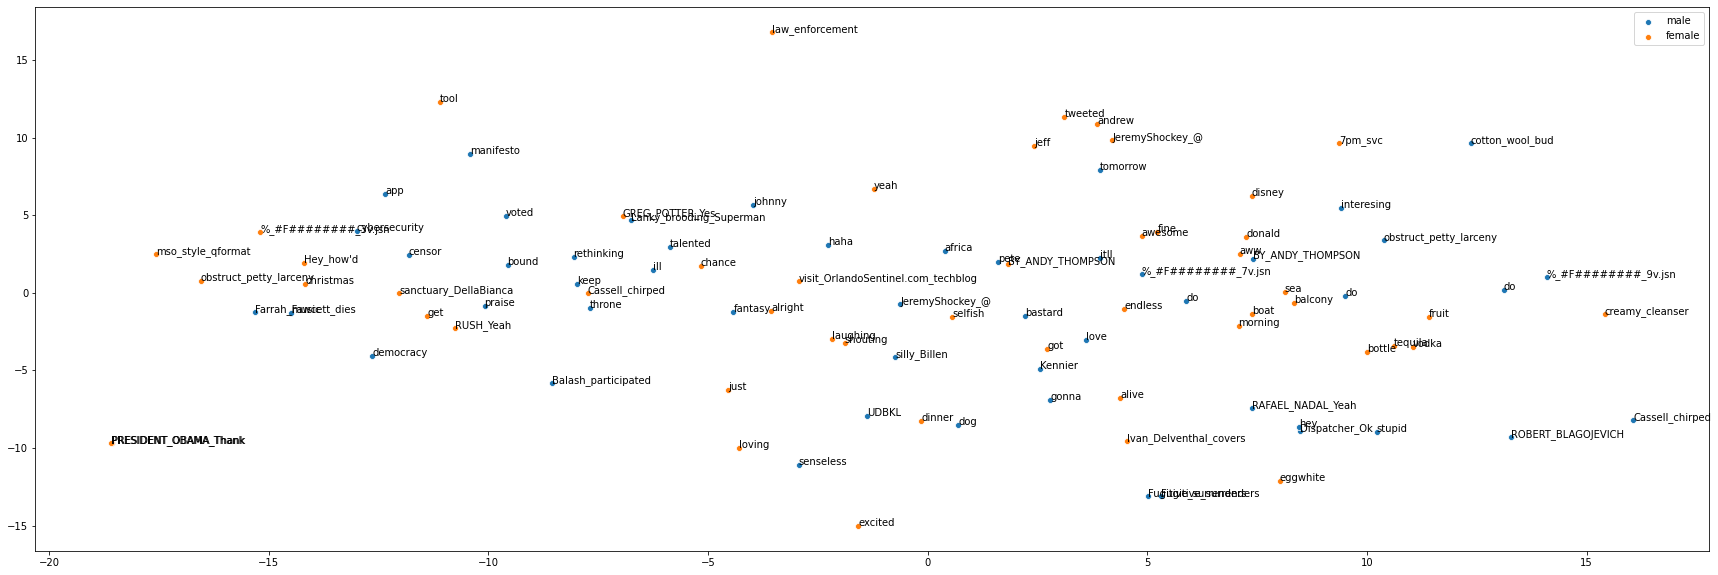

In [0]:
plt.figure(figsize = (30,10))
n = 200
delta = 50
plot_and_annotate(male_x[n:n+delta],M[n:n+delta],"male")
plot_and_annotate(female_x[n:n+delta],F[n:n+delta],"female")

In [0]:
plt.scatter(B[:,0], B[:,1], label = "bots")
plt.scatter(M[:,0], M[:,1], label = "male")
plt.legend()

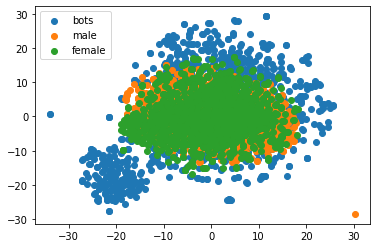

In [0]:
plt.scatter(B[:,0], B[:,1], label = "bots")
plt.scatter(M[:,0], M[:,1], label = "male")
plt.scatter(F[:,0], F[:,1], label = "female")
plt.legend()

In [0]:
ix = []
ixx = []
for i, b in enumerate(B):
  if b[0] < -10 and b[1] < -10:
    ix.append(i)
  else:
    ixx.append(i)

np.array(bot_txt)[ix][:10]


array([list(['senior', 'software', 'engineer', 'req', 'work', 'position', 'support', 'description', 'esoftware', 'job', 'advanced', 'project', 'candidate', 'program', 'codetitle']),
       list(['senior', 'engineer', 'shrewsbury', 'software', 'join', 'talented', 'infrastructure', 'benefit', 'large', 'role', 'team', 'currently', 'provider', 'joining', 'recruiting']),
       list(['information', 'development', 'year', 'control', 'andor', 'experience', 'mainframe', 'equivalent', 'degree', 'ten', 'developer', 'master', 'cics', 'customer', 'application', 'database', 'minimum', 'system', 'bachelor', 'management', 'specifically', 'cobol']),
       list(['salary', 'year', 'job', 'based', 'firmware', 'location', 'company', 'county', 'per', 'ago', 'durham', 'software', 'established', 'market', 'permanent', 'type', 'england', 'engineer', 'title', 'full', 'time', 'annum', 'peterlee']),
       list(['development', 'together', 'electronics', 'description', 'job', 'senior', 'available', 'brings', 'fu

# PERSONALITY


In [37]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, IncrementalPCA
import pdb
import matplotlib.pyplot as plt
from google.colab import drive
import gensim
import seaborn as sns
import pandas as pd

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

!pip install ipython-autotime
%load_ext autotime

model = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


time: 47 s


In [48]:
senti = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/corpus/Emotion_Lexicon.csv")
senti_words = list(senti["Words"])
senti

Words  anger  anticipation  ...  surprise  trust  Charged
0           march      0             0  ...         0      0        1
1          august      0             0  ...         0      0        1
2             ago      0             0  ...         0      0        0
3             mar      0             0  ...         0      0        1
4             vie      0             0  ...         0      0        0
...           ...    ...           ...  ...       ...    ...      ...
14177        zone      0             0  ...         0      0        0
14178         zoo      0             0  ...         0      0        0
14179  zoological      0             0  ...         0      0        0
14180     zoology      0             0  ...         0      0        0
14181        zoom      0             0  ...         0      0        0

[14182 rows x 12 columns]

In [58]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/corpus/train_data.csv")
print(df.head())
tweets,ys = df["tweet"], df["y"]

d = {"bot" : [], "male" : [], "female" : []}
for tweet,y in zip(tweets,ys):
  words = tweet.split()
  d[y] = d[y]+words 

   Unnamed: 0                                              tweet       y
0           0  unlock key break attacker trace finnish used s...     bot
1           1                                          fantastic  female
2           2  since list central africa south lion west elep...    male
3           3  blocked bird went tinder cracker jacob name be...    male
4           4      make vote easy saw possible resident job post    male


In [0]:
new_d = {"bot" : [], "male" : [], "female" : []}
for key in d:
  for w in d[key]:
    if w in senti_words:
      new_d[key].append(w)


In [70]:
senti[senti["Words"] == "contact"]

Words  anger  anticipation  disgust  ...  sadness  surprise  trust  Charged
2669  contact      0             0        0  ...        0         0      0        1

[1 rows x 12 columns]

In [0]:
senti_words = list(senti["Words"])
vecs = []
for word in senti_words:
  try:
    v = model.get_vector(word)
  except Exception:
    vecs.append([])
  vecs.append(v)

time: 37.9 ms


In [0]:
emotions = {"bot" : [], "male" : [], "female" : []}
for key in new_d:
  for w in new_d[key]:
    xs = senti[senti["Words"] == w]
    emotions[key].append(xs)

In [0]:
bot_list = emotions["bot"]
bot = pd.concat(bot_list)

male_list = emotions["male"]
male = pd.concat(male_list)

female_list = emotions["female"]
female = pd.concat(female_list)

KeyboardInterrupt: ignored

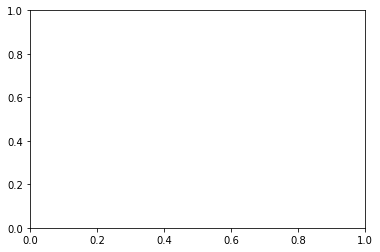

In [116]:
male.plot.bar(rot=0)

11 11


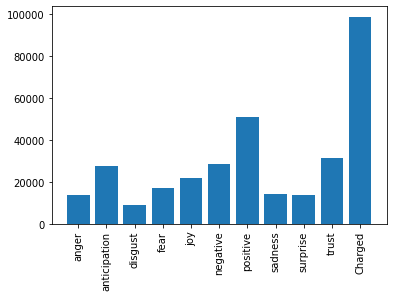

11 11


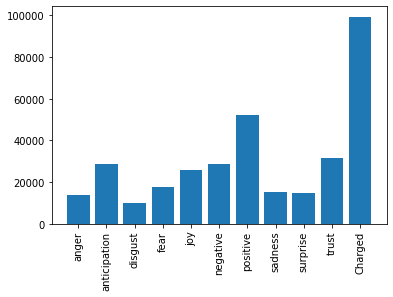

11 11


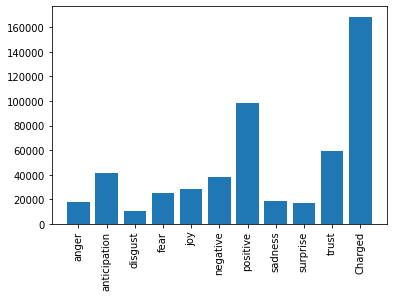

In [113]:
def vizualize(df):
  xs = ["anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust", "Charged"]
  anger = df["anger"].sum()
  anticipation = df["anticipation"].sum()
  disgust  = df["disgust"].sum()
  fear     = df["fear"].sum()
  joy      = df["joy"].sum()
  negative = df["negative"].sum()
  positive = df["positive"].sum()
  sadness  = df["sadness"].sum()
  surprise = df["surprise"].sum()
  trust    = df["trust"].sum()
  charged  = df["Charged"].sum()
  ys = [anger, anticipation, disgust, fear, joy, negative, positive, sadness, surprise, trust, charged]
  plt.bar(xs,ys)
  plt.xticks(rotation=90)
  print(len(ys), len(xs))
  plt.show()

vizualize(male)
vizualize(female)
vizualize(bot)


In [0]:
male.to_csv("male_senti.csv")
female.to_csv("female_senti.csv")
bot.to_csv("bot_senti.csv")

11 11


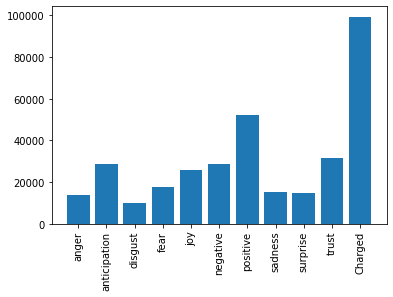

In [105]:
def vizualize(df):
  xs = ["anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust", "Charged"]
  anger = df["anger"].sum()
  anticipation = df["anticipation"].sum()
  disgust  = df["disgust"].sum()
  fear     = df["fear"].sum()
  joy      = df["joy"].sum()
  negative = df["negative"].sum()
  positive = df["positive"].sum()
  sadness  = df["sadness"].sum()
  surprise = df["surprise"].sum()
  trust    = df["trust"].sum()
  charged  = df["Charged"].sum()
  ys = [anger, anticipation, disgust, fear, joy, negative, positive, sadness, surprise, trust, charged]
  plt.bar(xs,ys)
  plt.xticks(rotation=90)
  print(len(ys), len(xs))

vizualize(female)

In [0]:
X = []
Y = []
with open("/content/gdrive/My Drive/Colab Notebooks/data/corpus/test_clean2", "r") as f:
  for line in f:
    sen,y = line.split(",") 
    xs = sen.split()
    X.append(xs)
    Y.append(y)

time: 465 ms


In [0]:
def get_most_similar(word, senti):
  xs = []
  for word_senti in senti:
    try:
      value = model.similarity(word, word_senti)
    except Exception:
      continue
    xs.append(value)
  
  if len(xs) == 0:
    return []
  xs = np.array(xs)
  return np.argmax(xs)

xs = []
n = 10000
for i, (words,y) in enumerate(zip(X[0:n],Y[0:n])):
  print(f"{i/len(Y[0:n])*100}")
  for word in words:
    ix = get_most_similar(word, senti_words)  
    if not ix:
      continue
    xs.append((word,ix,y))
  

In [0]:
male   = []
bot    = []
female = []
for w, ix, y in xs:
  y = y.strip()
  data = dict(senti.iloc[ix])
  if y == "male":
    male.append(data)
  elif y == "bot":
    bot.append(data)
  else:
    female.append(data)

In [0]:
import csv
csv_file    = "/content/gdrive/My Drive/Colab Notebooks/data/senti/bot.csv"
csv_columns = ["Charged", "Words", "anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"] 
try:
    with open(csv_file, 'w+') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
      writer.writeheader()
      for data in bot:
        writer.writerow(data)
except IOError:
    print("I/O error")

In [0]:
csv_file    = "/content/gdrive/My Drive/Colab Notebooks/data/senti/male.csv"
csv_columns = ["Charged", "Words", "anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"] 
try:
    with open(csv_file, 'w+') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
      writer.writeheader()
      for data in male:
        writer.writerow(data)
except IOError:
    print("I/O error")

time: 142 ms


In [0]:
csv_file    = "/content/gdrive/My Drive/Colab Notebooks/data/senti/female.csv"
csv_columns = ["Charged", "Words", "anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"] 
try:
    with open(csv_file, 'w') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
      writer.writeheader()
      for data in female:
        writer.writerow(data)
except IOError:
    print("I/O error")

time: 132 ms


#EDA


In [0]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

drive.mount("/content/gdrive")
!pip install ipython-autotime
%load_ext autotime


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.59 s


In [0]:
df  = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/corpus/train_data.csv", delimiter=",")
del df["Unnamed: 0"]

time: 253 ms


In [0]:
male = df[df["y"] == "male"]
female = df[df["y"] == "female"]
bot = df[df["y"] == "bot"]

time: 52.2 ms


In [0]:
words = []
for sentance in df["tweet"]:
  words.append(sentance.split())

male_words = []
for sentance in male["tweet"]:
  male_words.append(sentance.split())

female_words = []
for sentance in female["tweet"]:
  female_words.append(sentance.split())

bot_words = []
for sentance in bot["tweet"]:
  bot_words.append(sentance.split())  

time: 1.43 s


In [0]:
words = [item for sublist in words for item in sublist]
male_words = [item for sublist in male_words for item in sublist]
female_words = [item for sublist in female_words for item in sublist]
bot_words = [item for sublist in bot_words for item in sublist]

time: 205 ms


In [0]:
from nltk import Counter

def vizalize_most_common(words_list, k):
  plt.figure(figsize = (20,20))
  counter = Counter(words_list)
  most = counter.most_common()
  x, y= [], []
  for word,count in most[:k]:
        x.append(word)
        y.append(count)
  ax = sns.barplot(x=y,y=x)
  return ax



time: 5.19 ms


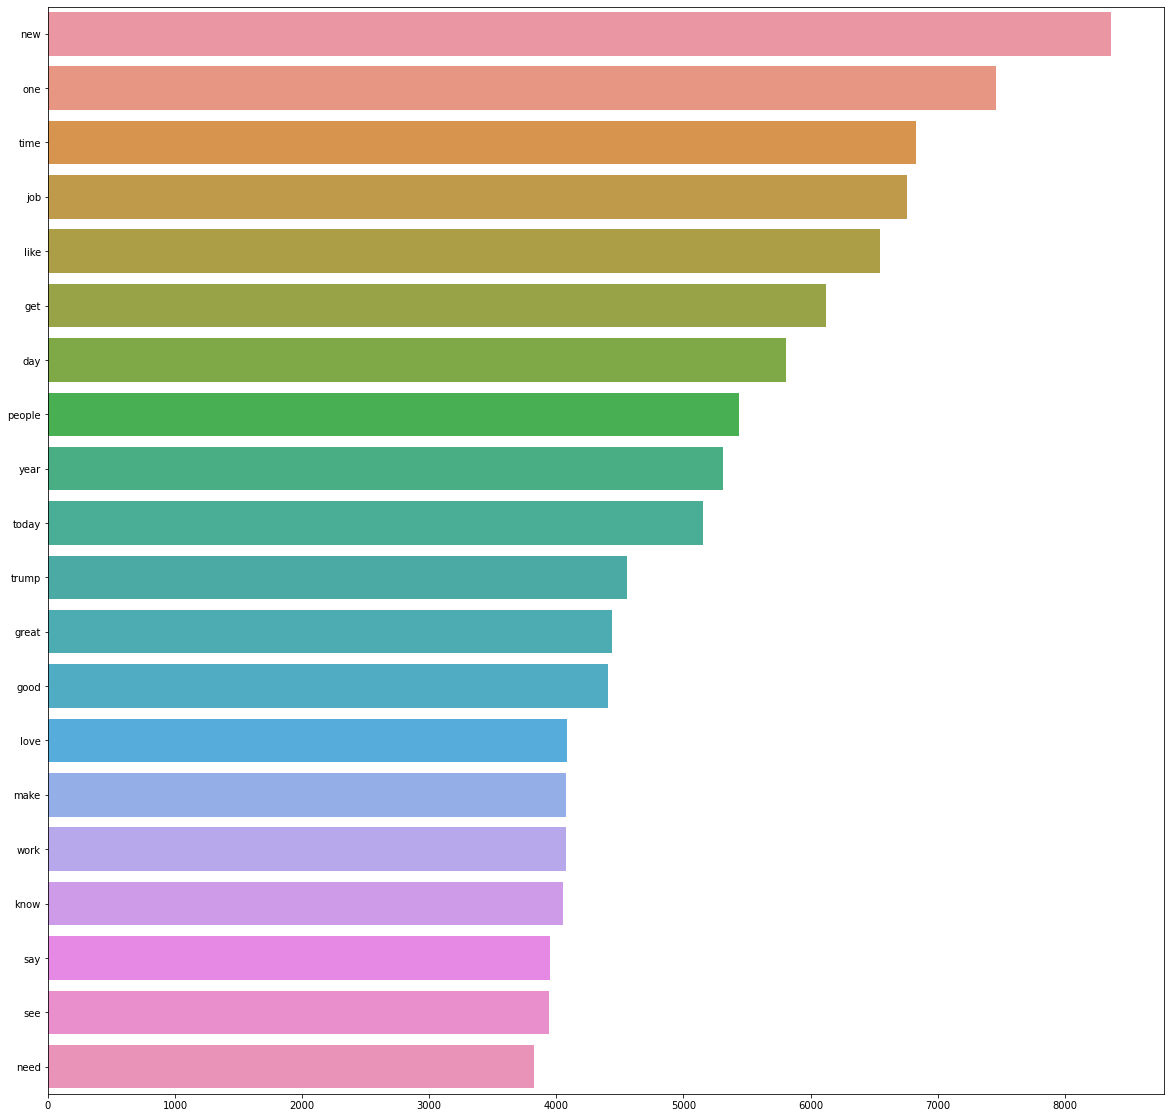

time: 1.02 s


In [0]:
ax = vizalize_most_common(words,20)
fig = ax.get_figure()
fig.savefig("/content/gdrive/My Drive/Colab Notebooks/data/all.png")

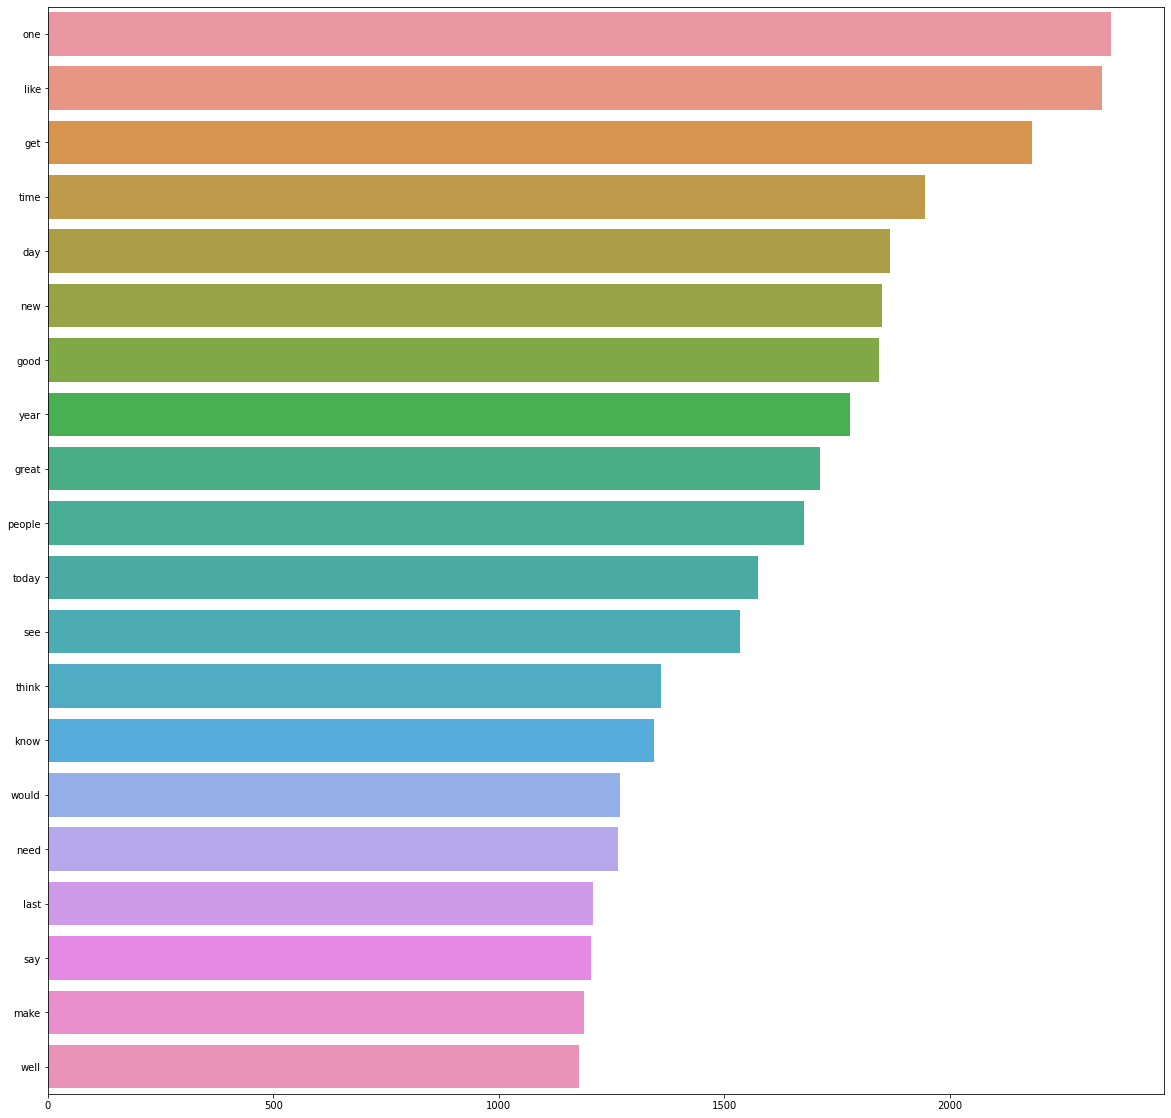

time: 1.07 s


In [0]:
ax = vizalize_most_common(male_words,20)
fig = ax.get_figure()
fig.savefig("/content/gdrive/My Drive/Colab Notebooks/data/m.png")

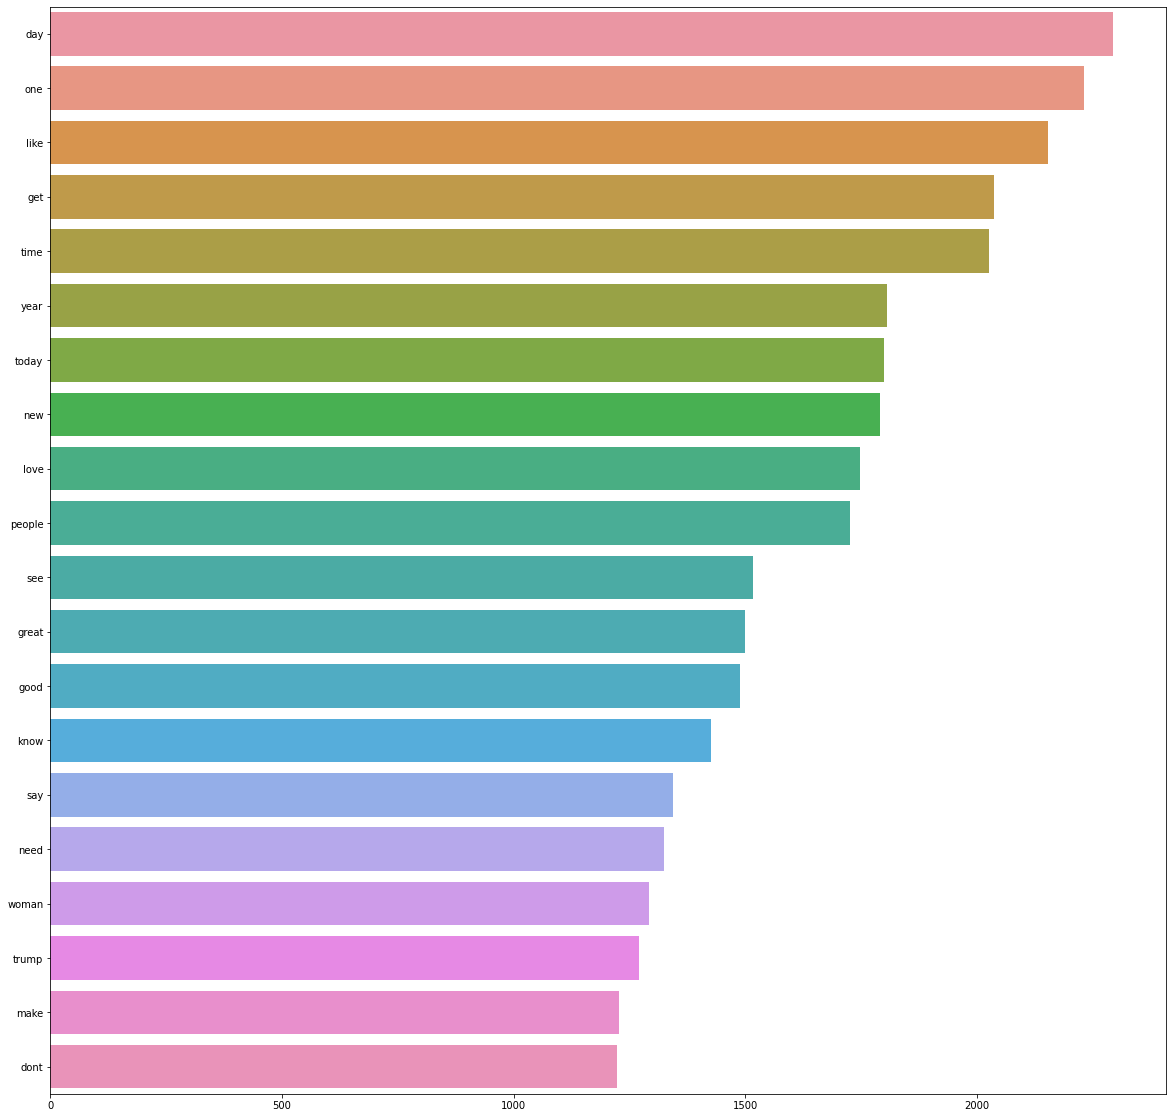

time: 788 ms


In [0]:
ax = vizalize_most_common(female_words,20)
fig = ax.get_figure()
fig.savefig("/content/gdrive/My Drive/Colab Notebooks/data/f.png")

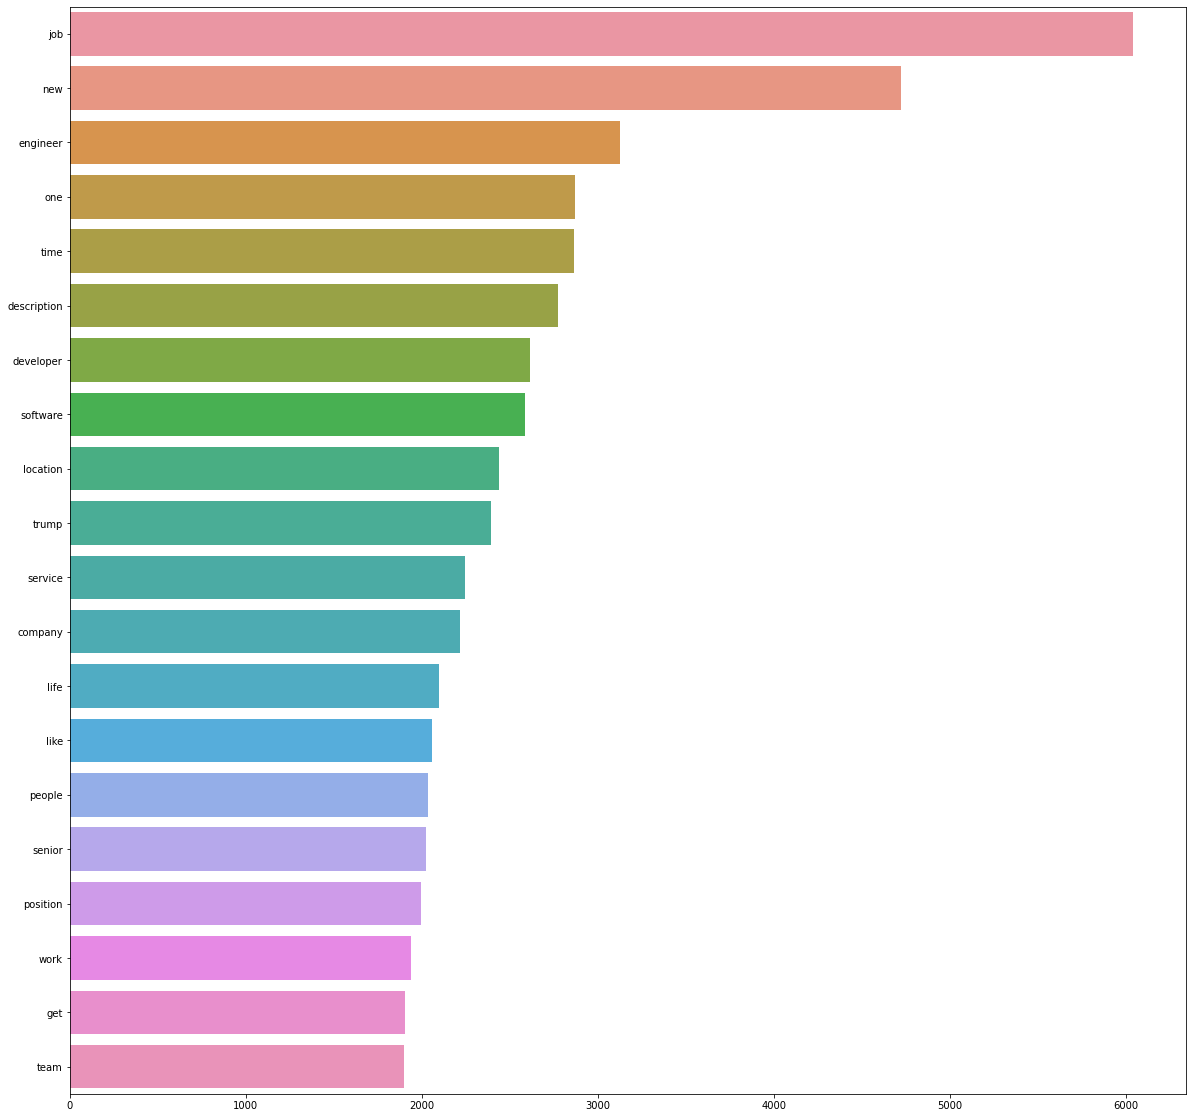

time: 874 ms


In [0]:
ax = vizalize_most_common(bot_words,20)
fig = ax.get_figure()
fig.savefig("/content/gdrive/My Drive/Colab Notebooks/data/b.png")

# SENTI 2

In [0]:
!pip install transformers


In [0]:
import transformers
import typing

In [0]:
!cd  /content/Aspect-Based-Sentiment-Analysis ; ls ; python setup.py install

aspect_based_sentiment_analysis  environment.yml  LICENSE    setup.py
data				 examples	  README.md  tests
2020-05-25 13:40:15.278427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "setup.py", line 2, in <module>
    import aspect_based_sentiment_analysis as absa
  File "/content/Aspect-Based-Sentiment-Analysis/aspect_based_sentiment_analysis/__init__.py", line 4, in <module>
    from .alignment import tokenize
  File "/content/Aspect-Based-Sentiment-Analysis/aspect_based_sentiment_analysis/alignment.py", line 10, in <module>
    from .data_types import TokenizedExample
  File "/content/Aspect-Based-Sentiment-Analysis/aspect_based_sentiment_analysis/data_types.py", line 4, in <module>
    from typing import OrderedDict
ImportError: cannot import name 'OrderedDict'
